# ULCC vs Legacy Carriers: Price, Passenger, and Elasticity Analysis
This notebook:
1. Tags ULCC vs Legacy airlines
2. Performs statistical and economic comparisons
3. Tests for fare elasticity with log-log regressions and interactions
4. Visualizes pricing impact across carrier types

## Tag ULCC vs Legacy Carriers

In [3]:
import pandas as pd

# Load data
df = pd.read_csv("../data/raw/raw_airline_data_sorted.csv")

# Keep only domestic region
df = df[df["REGION"] == "D"]

# Define ULCCs
ulcc_list = [
    "Spirit Air Lines",
    "Frontier Airlines",
    "Allegiant Air",
    "Sun Country Airlines",
]
df["CARRIER_TYPE"] = df["CARRIER_NAME"].apply(
    lambda x: "ULCC" if x in ulcc_list else "Legacy"
)

# Save processed file
df.to_csv("../data/processed/ulcc_vs_legacy_tagged.csv", index=False)
print("✅ Saved: ulcc_vs_legacy_tagged.csv")

✅ Saved: ulcc_vs_legacy_tagged.csv


## Compare Descriptive Stats by Carrier Type

In [4]:
df = pd.read_csv("../data/processed/ulcc_vs_legacy_tagged.csv")

grouped = df.groupby("CARRIER_TYPE")[
    ["DB1B_PASSENGERS", "MARKET_FARE", "MARKET_FARE_WEIGHTED"]
].agg(["mean", "std", "count"])
print(grouped)

             DB1B_PASSENGERS                       MARKET_FARE              \
                        mean           std   count        mean         std   
CARRIER_TYPE                                                                 
Legacy           6954.705062  16211.721829  647167  237.154166  159.072825   
ULCC             7305.757042  15939.838447   36957  181.628923   76.189971   

                     MARKET_FARE_WEIGHTED                      
               count                 mean         std   count  
CARRIER_TYPE                                                   
Legacy        647167           218.989258  123.712019  647167  
ULCC           36957           153.747393   73.420517   36957  


## Grouped Mean by Distance and Region

In [6]:
summary = (
    df.groupby(["CARRIER_TYPE", "DISTANCE_GROUP", "REGION"])[
        ["DB1B_PASSENGERS", "MARKET_FARE", "MARKET_FARE_WEIGHTED"]
    ]
    .mean()
    .reset_index()
)
summary.to_csv("../data/processed/ulcc_clustered_means.csv", index=False)
print("✅ Saved: ulcc_clustered_means.csv")
print(summary.head())

✅ Saved: ulcc_clustered_means.csv
  CARRIER_TYPE  DISTANCE_GROUP REGION  DB1B_PASSENGERS  MARKET_FARE  \
0       Legacy               1      D      4874.819947   215.851398   
1       Legacy               2      D      7264.139267   233.761114   
2       Legacy               3      D      9368.100132   251.416274   
3       Legacy               4      D      8347.007873   278.334621   
4       Legacy               5      D     14511.301654   311.649939   

   MARKET_FARE_WEIGHTED  
0            205.035890  
1            214.326208  
2            226.365849  
3            251.107849  
4            277.610475  


## Welch’s T-Test for ULCC vs Legacy Metrics

In [7]:
from scipy.stats import ttest_ind

ulcc = df[df["CARRIER_TYPE"] == "ULCC"]
legacy = df[df["CARRIER_TYPE"] == "Legacy"]

for metric in ["DB1B_PASSENGERS", "MARKET_FARE", "MARKET_FARE_WEIGHTED"]:
    ulcc_vals = ulcc[metric].dropna()
    legacy_vals = legacy[metric].dropna()
    t_stat, p_val = ttest_ind(ulcc_vals, legacy_vals, equal_var=False)

    print(f"\nWelch’s t-test for {metric}:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_val:.4f}")


Welch’s t-test for DB1B_PASSENGERS:
  T-statistic: 4.1141
  P-value: 0.0000

Welch’s t-test for MARKET_FARE:
  T-statistic: -125.3638
  P-value: 0.0000

Welch’s t-test for MARKET_FARE_WEIGHTED:
  T-statistic: -158.4636
  P-value: 0.0000


## Log-Log Price Elasticity (Overall + Separate by Carrier)

In [8]:
import numpy as np
import statsmodels.api as sm

# Filter out bad values
df = df[(df["DB1B_PASSENGERS"] > 0) & (df["MARKET_FARE"] > 0)]

# Log transform
df["log_passengers"] = np.log(df["DB1B_PASSENGERS"])
df["log_fare"] = np.log(df["MARKET_FARE"])

# --- Overall Elasticity ---
print("📊 Overall Price Elasticity")
X = sm.add_constant(df["log_fare"])
y = df["log_passengers"]
model = sm.OLS(y, X).fit()
print(model.summary())

# --- ULCC Only ---
print("\n🟡 ULCC-Only Price Elasticity")
ulcc_df = df[df["CARRIER_TYPE"] == "ULCC"]
X_ulcc = sm.add_constant(ulcc_df["log_fare"])
y_ulcc = ulcc_df["log_passengers"]
ulcc_model = sm.OLS(y_ulcc, X_ulcc).fit()
print(ulcc_model.summary())

# --- Legacy Only ---
print("\n🔵 Legacy-Only Price Elasticity")
legacy_df = df[df["CARRIER_TYPE"] == "Legacy"]
X_legacy = sm.add_constant(legacy_df["log_fare"])
y_legacy = legacy_df["log_passengers"]
legacy_model = sm.OLS(y_legacy, X_legacy).fit()
print(legacy_model.summary())

📊 Overall Price Elasticity
                            OLS Regression Results                            
Dep. Variable:         log_passengers   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2340.
Date:                Fri, 27 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:25:52   Log-Likelihood:            -1.5920e+06
No. Observations:              683271   AIC:                         3.184e+06
Df Residuals:                  683269   BIC:                         3.184e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9572    

## Interaction Model (Fare × ULCC Flag)

In [9]:
# Add binary ULCC flag and interaction
df["ULCC_FLAG"] = (df["CARRIER_TYPE"] == "ULCC").astype(int)
df["ULCC_log_fare"] = df["ULCC_FLAG"] * df["log_fare"]

X = sm.add_constant(df[["log_fare", "ULCC_FLAG", "ULCC_log_fare"]])
y = df["log_passengers"]
interaction_model = sm.OLS(y, X).fit()

print("📉 Price Elasticity with Carrier-Type Interaction")
print(interaction_model.summary())

📉 Price Elasticity with Carrier-Type Interaction
                            OLS Regression Results                            
Dep. Variable:         log_passengers   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1403.
Date:                Fri, 27 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:26:03   Log-Likelihood:            -1.5911e+06
No. Observations:              683271   AIC:                         3.182e+06
Df Residuals:                  683267   BIC:                         3.182e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

## Visualization – Log Fares vs Log Passengers by Carrier Type

/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_84878/2090467597.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["fare_bin", "CARRIER_TYPE"])


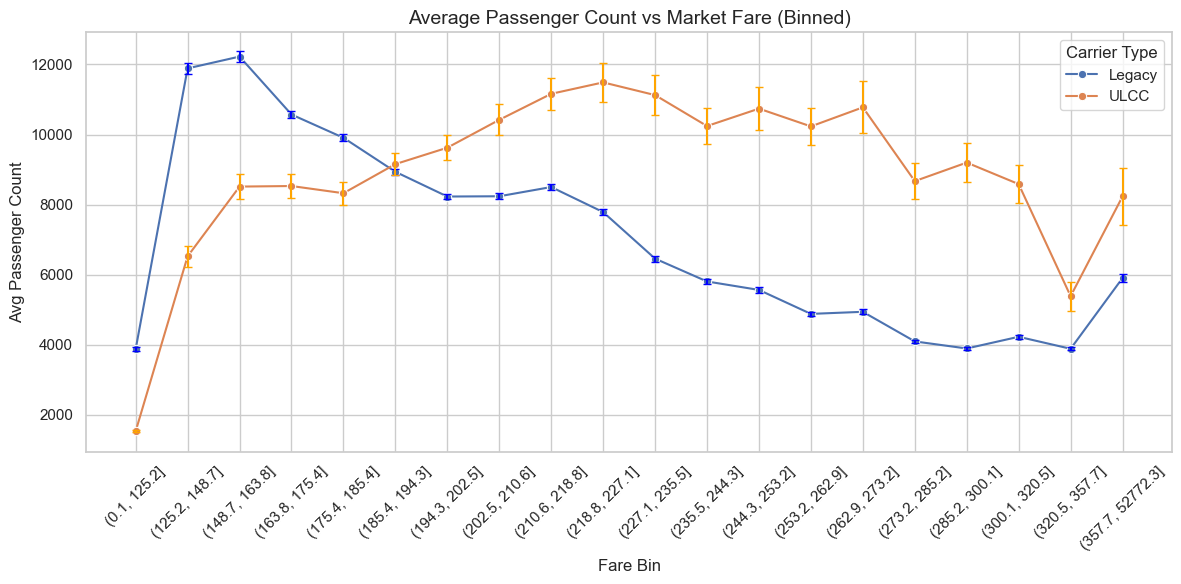

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[(df["MARKET_FARE"] > 0) & (df["DB1B_PASSENGERS"] > 0)]

# Bin fares
df["fare_bin"] = pd.qcut(df["MARKET_FARE"], q=20)

# Group and summarize
grouped = (
    df.groupby(["fare_bin", "CARRIER_TYPE"])
    .agg(
        avg_passengers=("DB1B_PASSENGERS", "mean"),
        std=("DB1B_PASSENGERS", "std"),
        count=("DB1B_PASSENGERS", "count"),
    )
    .reset_index()
)

# Add numeric-friendly x-axis
grouped["fare_bin_str"] = grouped["fare_bin"].apply(
    lambda x: f"({x.left:.1f}, {x.right:.1f}]"
)


# Estimate standard error
grouped["stderr"] = grouped["std"] / np.sqrt(grouped["count"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped, x="fare_bin_str", y="avg_passengers", hue="CARRIER_TYPE", marker="o"
)

# Add error bars
for carrier in grouped["CARRIER_TYPE"].unique():
    subset = grouped[grouped["CARRIER_TYPE"] == carrier]
    plt.errorbar(
        x=subset["fare_bin_str"],
        y=subset["avg_passengers"],
        yerr=subset["stderr"],
        fmt="none",
        capsize=3,
        color="orange" if carrier == "ULCC" else "blue",
    )

plt.xticks(rotation=45)
plt.title("Average Passenger Count vs Market Fare (Binned)", fontsize=14)
plt.xlabel("Fare Bin", fontsize=12)
plt.ylabel("Avg Passenger Count", fontsize=12)
plt.legend(title="Carrier Type")
plt.tight_layout()
plt.grid(True)
plt.savefig("elasticity_binned_plot_fixed.png", dpi=300)
plt.show()

- While legacy carriers command the highest volumes in ultra-low fare bins, ULCCs consistently surpass them across mid-price segments (approx. $160–$280), suggesting a strategic concentration of demand on fewer, high-volume routes. 
- This supports the statistical finding that ULCCs, despite serving fewer routes, average slightly higher passenger volume per route than legacy airlines.